In [ ]:
!pip install imblearn
!pip install xgboost

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import csv
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Step 1: Detect delimiter automatically
def detect_delimiter(file_path):
    with open(file_path, 'r', encoding="utf-8") as file:
        sample = file.readline()
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(sample).delimiter
        return delimiter

# Step 2: Safe CSV loader
def safe_load_csv(file_path):
    try:
        delimiter = detect_delimiter(file_path)
        df = pd.read_csv(file_path, delimiter=delimiter, low_memory=False)
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
new_fraud_dataset = safe_load_csv("/Users/sahithibikumalla/Downloads/new_fraud_data.csv")

# Display first 5 rows of each dataset
if new_fraud_dataset is not None:
    print("\n new_fraud_dataset:")
    display(new_fraud_dataset.head())


 new_fraud_dataset:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_30,id_31,DeviceInfo,TransactionAmt_log,card1_freq,card2_freq,TransactionHour,is_US,P_email_cat,R_email_cat
0,2987000,0,86400,68.5,W,13926,361.0,150.0,discover,142.0,...,UNK,UNK,UNK,4.241327,43,10126.0,0,True,missing,missing
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,UNK,UNK,UNK,3.401197,683,3056.0,0,True,us,missing
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,UNK,UNK,UNK,4.094345,1108,38145.0,0,True,us,missing
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,UNK,UNK,UNK,3.931826,4209,6137.0,0,True,us,missing
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,Android 7.0,samsung browser 6.2,SAMSUNG SM-G892A Build/NRD90M,3.931826,18,14541.0,0,True,us,missing


In [ ]:
# Identify object (string) columns
categorical_cols = new_fraud_dataset.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", categorical_cols)


Categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6', 'id_30', 'id_31', 'DeviceInfo', 'P_email_cat', 'R_email_cat']


In [ ]:
# List of low-cardinality categorical columns to one-hot encode
cols_to_encode = ['ProductCD', 'card4', 'card6', 'P_email_cat', 'R_email_cat']

# One-hot encode and concatenate with the dataset
df_encoded = pd.get_dummies(new_fraud_dataset, columns=cols_to_encode, drop_first=True)

# Show new shape and column sample
print("New shape after encoding:", df_encoded.shape)
df_encoded.columns[-10:]  # Show last few columns to confirm  


New shape after encoding: (590540, 237)


Index(['P_email_cat_us', 'R_email_cat_es', 'R_email_cat_jp',
       'R_email_cat_missing', 'R_email_cat_mx', 'R_email_cat_other',
       'R_email_cat_private', 'R_email_cat_suspicious', 'R_email_cat_uk',
       'R_email_cat_us'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

high_card_cols = ['DeviceInfo', 'id_30', 'id_31']

# Apply Label Encoding
le = LabelEncoder()
for col in high_card_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


In [ ]:
from sklearn.model_selection import train_test_split

# Load preprocessed & encoded dataset
df_model1 = df_encoded.copy()

# Define features and target
X1 = df_model1.drop(['isFraud', 'TransactionID'], axis=1)
y1 = df_model1['isFraud']

# Train/Test split without balancing
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=42)

print("Class balance in training set:\n", y1_train.value_counts())


Class balance in training set:
 isFraud
0    455902
1     16530
Name: count, dtype: int64


*   Used an 80-20 train-test split to separate training and evaluation data. This ensures fair testing on unseen data.


In [ ]:
non_numeric_cols = X1_train.select_dtypes(include='object').columns
print("Non-numeric columns:", non_numeric_cols.tolist())


Non-numeric columns: ['P_emaildomain', 'M6']


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_cols:
    X1_train[col] = le.fit_transform(X1_train[col].astype(str))
    X1_test[col] = le.transform(X1_test[col].astype(str))  # use same encoder


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Copy dataset
df_scaled = new_fraud_dataset.copy()

# Select only numeric columns (exclude isFraud and TransactionID)
numeric_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(['TransactionID', 'isFraud'])  # keep target untouched
scaler = MinMaxScaler()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
# Show summary stats of scaled features
print(df_scaled[numeric_cols].describe().T[['min', 'max']].head(10))


                min  max
TransactionDT   0.0  1.0
TransactionAmt  0.0  1.0
card1           0.0  1.0
card2           0.0  1.0
card3           0.0  1.0
card5           0.0  1.0
addr1           0.0  1.0
addr2           0.0  1.0
C1              0.0  1.0
C2              0.0  1.0


<h3>Approach/Model-2 Oversampling (SMOTE)</h3>

Now that we have tested the models on imbalanced data, here we will be using the Synthetic Minority Oversampling Techniques (SMOTE) to upsample the fraud case by synthetically creating some fraud case to match the non-fraud case. This will help balanced the train dataset after the train and test split. The model will trained on balanced dataset and predicts the probabilities on the test data. 

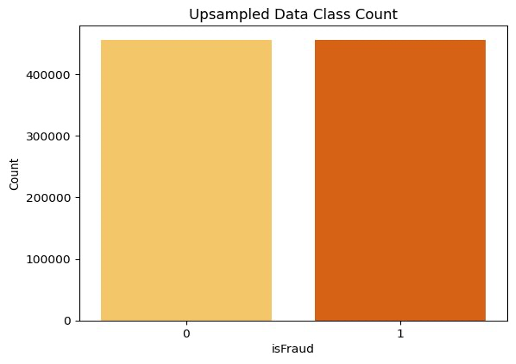

In [ ]:
X = df_scaled.drop(['TransactionID', 'isFraud'], axis=1)
y = df_scaled['isFraud']


In [ ]:
non_numeric_cols = X.select_dtypes(include='object').columns
print("Non-numeric columns:", non_numeric_cols.tolist())
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))


Non-numeric columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6', 'id_30', 'id_31', 'DeviceInfo', 'P_email_cat', 'R_email_cat']


Began by separating our features (X) from the target variable (y = isFraud) and dropped unnecessary identifiers like TransactionID. To prepare for modeling, checked for any non-numeric columns in X that needed encoding. These categorical variables were then transformed using LabelEncoder to ensure compatibility with machine learning models.

In [ ]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution after SMOTE:
isFraud
0    455902
1    455902
Name: count, dtype: int64


split the data into training and test sets using a stratified approach to maintain the original fraud ratio in both sets. Since the dataset was highly imbalanced, we applied SMOTE (Synthetic Minority Over-sampling Technique) to the training data. This helped generate synthetic fraud cases and balance the class distribution.

In [ ]:
non_numeric_cols = X_test.select_dtypes(include='object').columns
print("Non-numeric columns in X_test:", non_numeric_cols.tolist())
from sklearn.preprocessing import LabelEncoder

for col in non_numeric_cols:
    le = LabelEncoder()
    all_vals = pd.concat([X_train[col], X_test[col]]).astype(str)  # to avoid unseen values
    le.fit(all_vals)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


Non-numeric columns in X_test: []


After SMOTE, rechecked the test set for any remaining non-numeric features and encoded them properly.And made sure to fit the LabelEncoder on the combined values from both training and test sets to avoid errors from unseen categories during testing.

Here we continued with the same models that we implemented on Approach/Model 1 to maintain the comparison among the same models based on different data balancing techniques. 



=== Model 2: Random Forest (SMOTE) ===
Precision: 0.887546468401487
Recall: 0.46213404306798933
F1 Score: 0.6077963404932378
ROC AUC Score: 0.9205750939625514


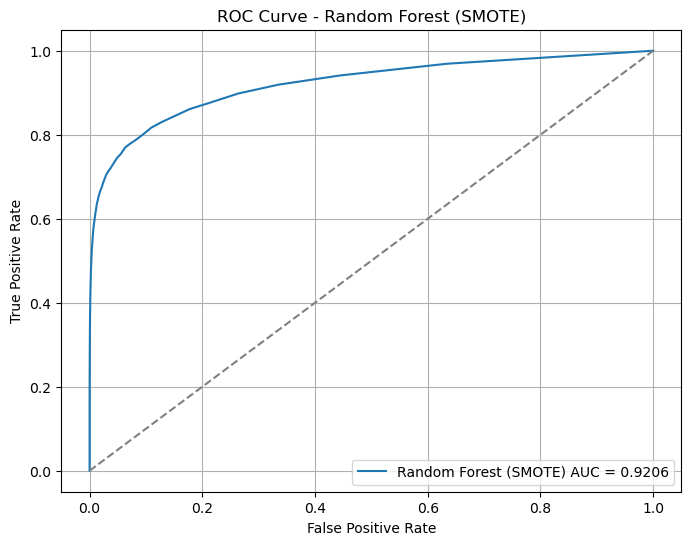

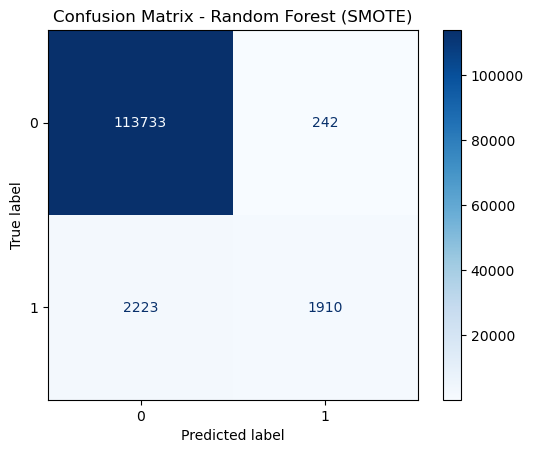

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on original (imbalanced) test set
y_pred_rf_smote = rf_smote.predict(X_test)
y_probs_rf_smote = rf_smote.predict_proba(X_test)[:, 1]
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

print("=== Model 2: Random Forest (SMOTE) ===")
print("Precision:", precision_score(y_test, y_pred_rf_smote))
print("Recall:", recall_score(y_test, y_pred_rf_smote))
print("F1 Score:", f1_score(y_test, y_pred_rf_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs_rf_smote))
fpr_rf_s, tpr_rf_s, _ = roc_curve(y_test, y_probs_rf_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_s, tpr_rf_s, label=f"Random Forest (SMOTE) AUC = {roc_auc_score(y_test, y_probs_rf_smote):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_smote, display_labels=rf_smote.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (SMOTE)")
plt.show()


precision of 88.7%, meaning most of the frauds it predicted were correct. The recall was 46.2%, indicating that the model was able to catch nearly half of the actual fraud cases. The F1 Score of 60.8% shows a balanced trade-off between precision and recall. The ROC AUC Score of 92.1% reflects strong overall discrimination ability between fraud and non-fraud transactions. While this model improved recall slightly compared to the imbalanced version, the original Random Forest without SMOTE still maintained a better precision-recall balance overall.

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best Parameters (SMOTE): {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Tuned XGBoost (SMOTE) Performance:
Precision: 0.7842306061890632
Recall: 0.44761674328574885
F1 Score: 0.5699322242760321
ROC AUC Score: 0.9143631130453123


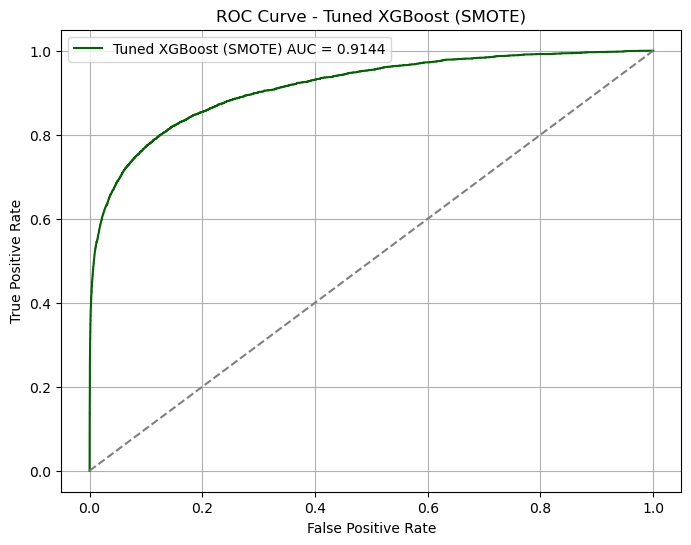

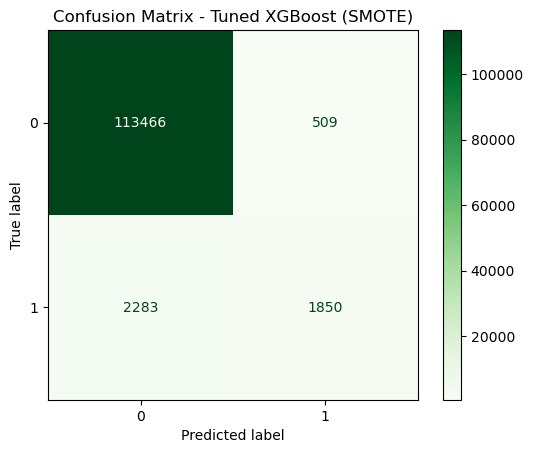

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_smote_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search_smote = GridSearchCV(
    estimator=xgb_smote_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search_smote.fit(X_train_smote, y_train_smote)
best_xgb_smote = grid_search_smote.best_estimator_
print("Best Parameters (SMOTE):", grid_search_smote.best_params_)

# Predict on original test set
y_pred_best_xgb_smote = best_xgb_smote.predict(X_test)
y_probs_best_xgb_smote = best_xgb_smote.predict_proba(X_test)[:, 1]
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

print("Tuned XGBoost (SMOTE) Performance:")
print("Precision:", precision_score(y_test, y_pred_best_xgb_smote))
print("Recall:", recall_score(y_test, y_pred_best_xgb_smote))
print("F1 Score:", f1_score(y_test, y_pred_best_xgb_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs_best_xgb_smote))
fpr_best, tpr_best, _ = roc_curve(y_test, y_probs_best_xgb_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f"Tuned XGBoost (SMOTE) AUC = {roc_auc_score(y_test, y_probs_best_xgb_smote):.4f}", color="darkgreen")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned XGBoost (SMOTE)")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm_best_xgb_smote = confusion_matrix(y_test, y_pred_best_xgb_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_xgb_smote, display_labels=best_xgb_smote.classes_)
disp.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix - Tuned XGBoost (SMOTE)")
plt.show()


Best Parameters (SMOTE): {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

This model used XGBoost with tuned settings and SMOTE to balance the data and used GridsearchCV . It had a precision of 78.4%, meaning most frauds it predicted were actually correct. The recall was 44.8%, so it found about 45 out of every 100 real frauds. The F1 Score was 56.9%, showing a fair balance between precision and recall. The ROC AUC score was 91.4%, which means the model was good at separating fraud from non-fraud overall. While the model performed well, it was not as strong as Random Forest, which had better precision and more stable results.



y_test shape: (118108,)
y_pred_log_smote shape: (118108,)
y_probs_log_smote shape: (118108,)

=== Model 2: Logistic Regression (SMOTE) ===
Precision: 0.0814038706875492
Recall: 0.7256230341156545
F1 Score: 0.14638551276419193
ROC AUC Score: 0.793730335185951


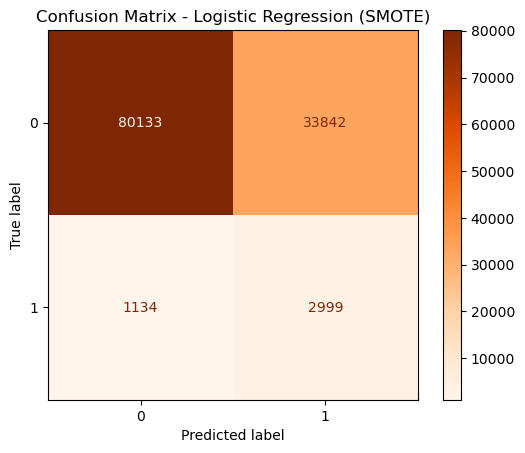

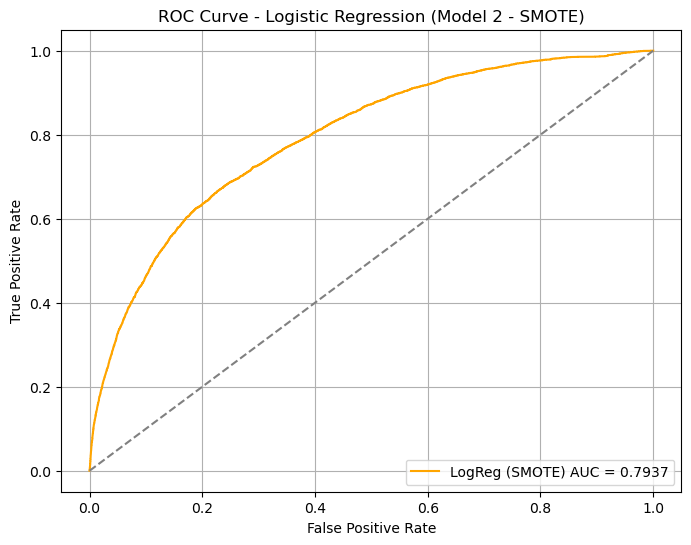

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
import matplotlib.pyplot as plt

# 1. Train on SMOTE-balanced data
log_reg_smote = LogisticRegression(max_iter=1000, random_state=42)
log_reg_smote.fit(X_train_smote, y_train_smote)

# 2. Predict on the original (imbalanced) test set
y_pred_log_smote = log_reg_smote.predict(X_test)
y_probs_log_smote = log_reg_smote.predict_proba(X_test)[:, 1]

# 3. Confirm consistency
print("y_test shape:", y_test.shape)
print("y_pred_log_smote shape:", y_pred_log_smote.shape)
print("y_probs_log_smote shape:", y_probs_log_smote.shape)

#  4. Evaluation Metrics
print("\n=== Model 2: Logistic Regression (SMOTE) ===")
print("Precision:", precision_score(y_test, y_pred_log_smote))
print("Recall:", recall_score(y_test, y_pred_log_smote))
print("F1 Score:", f1_score(y_test, y_pred_log_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs_log_smote))

#  5. Confusion Matrix
cm_log_smote = confusion_matrix(y_test, y_pred_log_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_smote, display_labels=log_reg_smote.classes_)
disp.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (SMOTE)")
plt.show()

#  6. ROC Curve
fpr_log_s, tpr_log_s, _ = roc_curve(y_test, y_probs_log_smote)
auc_log_s = roc_auc_score(y_test, y_probs_log_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log_s, tpr_log_s, label=f"LogReg (SMOTE) AUC = {auc_log_s:.4f}", color="orange")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Model 2 - SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



This version of logistic regression was trained using balanced data created with SMOTE. It achieved a very high recall of 72.6%, meaning it caught most fraud cases. However, its precision was very low at 8.1%, which means many of the predicted frauds were actually not fraud. Its F1 Score was 14.6%, and the ROC AUC score was 79.4%, showing decent overall classification ability. While it was good at finding frauds, it also made many false alarms, so it might not be ideal when accuracy and precision are critical.

=== Model 2: CatBoost (SMOTE) ===
Precision: 0.9092422980849292
Recall: 0.5284297120735543
F1 Score: 0.6684009181331293
ROC AUC Score: 0.946534015109689


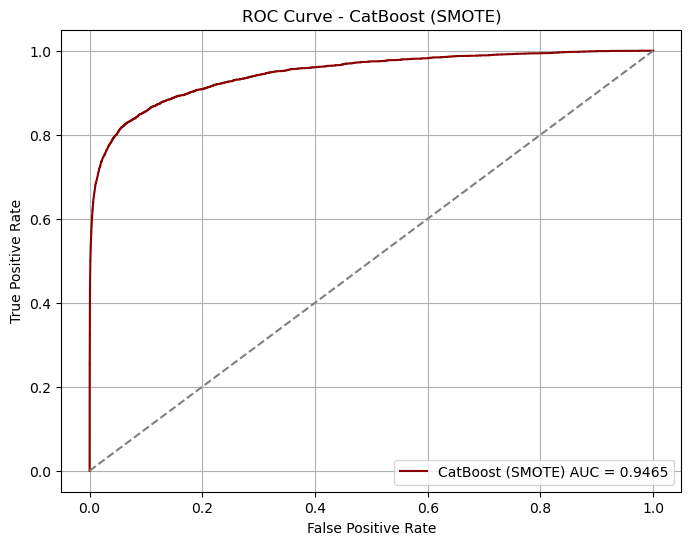

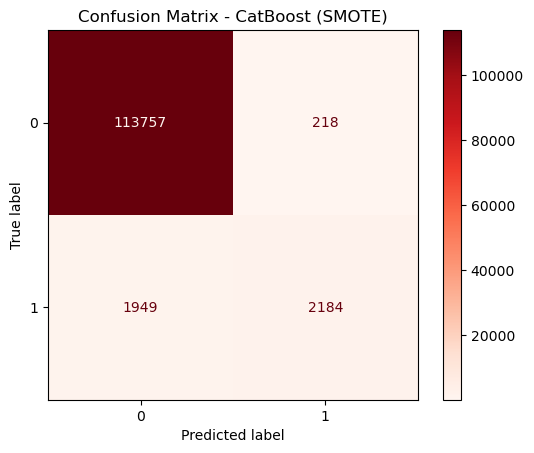

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

# Initialize and train model
cat_model_smote = CatBoostClassifier(verbose=0, random_state=42)
cat_model_smote.fit(X_train_smote, y_train_smote)

# Predict on original (imbalanced) test set
y_pred_cat_smote = cat_model_smote.predict(X_test)
y_probs_cat_smote = cat_model_smote.predict_proba(X_test)[:, 1]
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

print("=== Model 2: CatBoost (SMOTE) ===")
print("Precision:", precision_score(y_test, y_pred_cat_smote))
print("Recall:", recall_score(y_test, y_pred_cat_smote))
print("F1 Score:", f1_score(y_test, y_pred_cat_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs_cat_smote))
fpr_cat_s, tpr_cat_s, _ = roc_curve(y_test, y_probs_cat_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cat_s, tpr_cat_s, label=f"CatBoost (SMOTE) AUC = {roc_auc_score(y_test, y_probs_cat_smote):.4f}", color="darkred")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost (SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
cm_cat_smote = confusion_matrix(y_test, y_pred_cat_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cat_smote, display_labels=cat_model_smote.classes_)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - CatBoost (SMOTE)")
plt.show()


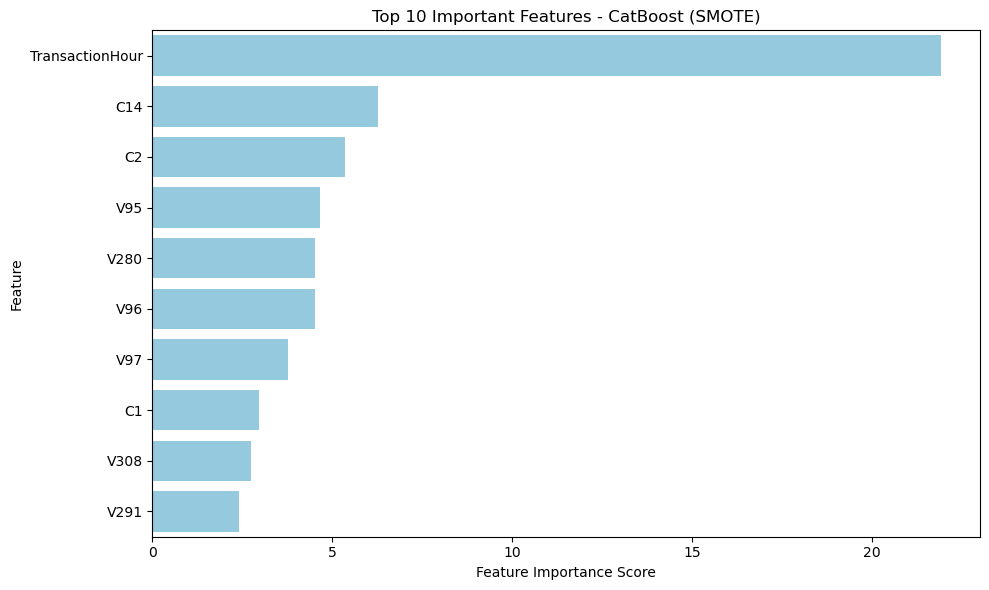

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importance
cat_importances = cat_model_smote.get_feature_importance()
feature_names = X_train_smote.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_importances
})

# Top 10 features
top10_cat = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_cat, color='skyblue')  # single color bar
plt.title("Top 10 Important Features - CatBoost (SMOTE)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


CatBoost trained with SMOTE performed quite well, especially in finding frauds. It had a precision of 90.9%, meaning most flagged frauds were truly fraud, and a recall of 52.8%, meaning it caught over half of all fraud cases. The F1 Score was 66.8%, showing a good balance between precision and recall. The ROC AUC score was 94.6%, which is very strong and indicates reliable classification performance. This model is effective when both catching fraud and reducing false alarms are important.

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define function to extract metrics
def get_metrics(y_true, y_pred, y_probs, model_name):
    return {
        "Model": model_name,
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_probs)
    }

# Extract metrics
rf_smote_metrics   = get_metrics(y_test, y_pred_rf_smote, y_probs_rf_smote, "Random Forest (SMOTE)")
xgb_smote_metrics  = get_metrics(y_test, y_pred_best_xgb_smote, y_probs_best_xgb_smote, "Tuned XGBoost (SMOTE)")
log_smote_metrics  = get_metrics(y_test, y_pred_log_smote, y_probs_log_smote, "Logistic Regression (SMOTE)")
cat_smote_metrics  = get_metrics(y_test, y_pred_cat_smote, y_probs_cat_smote, "CatBoost (SMOTE)")

# Build comparison DataFrame
model2_comparison_df = pd.DataFrame([
    rf_smote_metrics,
    xgb_smote_metrics,
    log_smote_metrics,
    cat_smote_metrics
])

# Arrange columns
model2_comparison_df = model2_comparison_df[["Model", "Precision", "Recall", "F1 Score", "ROC AUC"]]

# Display
print(" Model 2 Classifier Comparison (SMOTE Balanced Data):")
display(model2_comparison_df.round(4))


 Model 2 Classifier Comparison (SMOTE Balanced Data):


,Model,Precision,Recall,F1 Score,ROC AUC
0,Random Forest (SMOTE),0.8875,0.4621,0.6078,0.9206
1,Tuned XGBoost (SMOTE),0.7842,0.4476,0.5699,0.9144
2,Logistic Regression (SMOTE),0.0814,0.7256,0.1464,0.7937
3,CatBoost (SMOTE),0.9092,0.5284,0.6684,0.9465


Among all the models tested, CatBoost with SMOTE oversampling gave the most balanced and reliable results. It achieved a high precision of 90.9% and the highest recall at 52.8%, meaning it not only flagged most fraud cases correctly but also missed fewer of them. Its F1 Score of 66.8% was better than the others, showing a strong balance between catching fraud and keeping false positives low. With the highest ROC AUC score of 94.6%, CatBoost clearly showed superior overall performance in both accuracy and stability, making it the best choice for this fraud detection task.